In [1]:
import os
import time
import librosa
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange,tqdm
import scipy 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
from sklearnex import patch_sklearn, config_context

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = os.getcwd() + "/STFT_npy_dataset/"
path

'D:\\Study\\Code\\Python\\Sound_Classification_Bee_Qeen_Queenless/STFT_npy_dataset/'

In [3]:
TRAINING_DIR = path+"/train"
VALIDATION_DIR = path + "/val"
TEST_DIR = path + "/test"

print(TRAINING_DIR)
print(VALIDATION_DIR)
print(TEST_DIR)

D:\Study\Code\Python\Sound_Classification_Bee_Qeen_Queenless/STFT_npy_dataset//train
D:\Study\Code\Python\Sound_Classification_Bee_Qeen_Queenless/STFT_npy_dataset//val
D:\Study\Code\Python\Sound_Classification_Bee_Qeen_Queenless/STFT_npy_dataset//test


In [4]:
def data_loader(path):
    X = []
    Y = []
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            feature = np.load(os.path.join(path, folder, file))
            label = folder
            X += feature.tolist()
            Y += [label]*feature.shape[0]
    return X, Y

In [5]:
X_train, Y_train = data_loader(TRAINING_DIR)
X_val, Y_val = data_loader(VALIDATION_DIR)
X_test, Y_test = data_loader(TEST_DIR)

In [6]:
print("There are {} training samples and {} training labels".format(len(X_train), len(Y_train)))
print("There are {} validation samples and {} validation labels".format(len(X_val), len(Y_val)))
print("There are {} testing samples and {} testing labels".format(len(X_test), len(Y_test)))

There are 14000 training samples and 14000 training labels
There are 2000 validation samples and 2000 validation labels
There are 4000 testing samples and 4000 testing labels


In [7]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of Y_val: {}".format(Y_val.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (14000, 1026)
Shape of X_val: (2000, 1026)
Shape of X_test: (4000, 1026)
Shape of Y_train: (14000,)
Shape of Y_val: (2000,)
Shape of Y_test: (4000,)


In [8]:
X_test = np.vstack((X_test, X_val))
Y_test = np.hstack((Y_test, Y_val))
Y_train = Y_train.reshape((Y_train.shape[0], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))


print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of Y_train: {}".format(Y_train.shape))
print("Shape of Y_test: {}".format(Y_test.shape))

Shape of X_train: (14000, 1026)
Shape of X_test: (6000, 1026)
Shape of Y_train: (14000, 1)
Shape of Y_test: (6000, 1)


In [9]:
X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [10]:
# shuffle_index = np.random.permutation(len(X_train))
# X_train, Y_train = X_train[shuffle_index], Y_train[shuffle_index]
# shuffle_index = np.random.permutation(len(X_test))
# X_test, Y_test = X_test[shuffle_index], Y_test[shuffle_index]

In [11]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)
np.unique(Y_test)

array([0, 1])

In [12]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
print(X_train.shape)
print(X_train[0:5,:])

(14000, 1026)
[[ 1.97348117e-01  9.77980475e-02  5.57847930e-02 ...  1.15017633e-01
   8.38334518e-02  1.02181118e-01]
 [-3.62935505e-01 -3.75841849e-01 -4.26281223e-01 ... -6.78658549e-02
  -1.08136253e-04  1.77375795e-01]
 [ 1.63248338e-01  3.03584561e-02  5.73737868e-01 ... -4.13452996e-02
  -2.17979827e-02  2.99184299e-02]
 [ 6.87676792e-02 -2.30697766e-01 -4.15565758e-01 ... -1.31236353e-01
   1.62681476e-01  1.84707110e-01]
 [-4.27410644e-01 -4.11749031e-01 -1.79949877e-01 ... -2.50431383e-01
  -2.47825836e-01 -2.10453717e-01]]


In [13]:
global SEED 
SEED = 1337

In [14]:
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)] # Nhiều quá -> 100, 200, 500, 1000, 2000
n_estimators = [100, 200, 500, 1000, 2000]
max_features = [2, 4, 5 ,9, 10, 15, 18] #Trong bai cua co la 2, 4, 5 ,9, 10, 15, 18
min_samples_split = [2, 5, 11] # Trong bai la 5, 11 #Nên lấy số lẻ

# max_depth = [int(x) for x in np.linspace(5, 110, num = 22)] -> 2, 5, 8, 10, None
max_depth = [2, 5, 8, 10,] #-> 2, 5, 8, 10, None
max_depth.append(None)
criterion = ['gini', 'entropy', 'log_loss']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
Random_forest_search = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion': criterion
}
print(Random_forest_search)


SVM_search = {
              'C': scipy.stats.expon(scale=1.),
              'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              }
# remove kernel "precomputed" because of error: "https://stackoverflow.com/questions/36306555/scikit-learn-grid-search-with-svm-regression"
print(SVM_search)

n_neighbors = [int(x) for x in np.arange(5, 21)]
KNN_search = {'n_neighbors' : n_neighbors,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']
                   }
print(KNN_search)

Logistic_regression_search = {'penalty' : ['l1', 'l2', 'elasticnet', None],
                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                   'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
                    }
print(Logistic_regression_search)

Extra_trees_search = {'n_estimators': [int(x) for x in np.arange(50, 126, 5)],
                    'max_features': [int(x) for x in np.arange(50, 401, 50)],
                    'min_samples_leaf':  [int(x) for x in np.arange(20, 51, 5)],
                    'min_samples_split': [int(x) for x in np.arange(15, 36, 5)],
                    }
print(Extra_trees_search)

XGBoost_search = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
print(XGBoost_search)

{'n_estimators': [100, 200, 500, 1000, 2000], 'max_features': [2, 4, 5, 9, 10, 15, 18], 'max_depth': [2, 5, 8, 10, None], 'min_samples_split': [2, 5, 11], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy', 'log_loss']}
{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002532A36DB80>, 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002535D727E20>, 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
{'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean', 'manhattan']}
{'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
{'n_estimators': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125], 'max_features': [50, 100, 150, 2

In [15]:
classifiers = [['ExtraTreesClassifier', ExtraTreesClassifier(random_state=SEED), Extra_trees_search],
                ['LogisticRegression', LogisticRegression(random_state=SEED), Logistic_regression_search],
              ['KNeighborsClassifier', KNeighborsClassifier(), KNN_search],
              ['RandomForestClassifier', RandomForestClassifier(random_state=SEED), Random_forest_search],
                ['XGBClassifier', XGBClassifier(random_state=SEED), XGBoost_search],
               ['SVC',SVC(probability = True, random_state=SEED), SVM_search]
]

In [16]:
classifiers[0][1]

ExtraTreesClassifier(random_state=1337)

In [17]:
global cv
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=SEED)
global X_train, Y_train, X_test, Y_test
print(X_train[:5])

[[ 1.97348117e-01  9.77980475e-02  5.57847930e-02 ...  1.15017633e-01
   8.38334518e-02  1.02181118e-01]
 [-3.62935505e-01 -3.75841849e-01 -4.26281223e-01 ... -6.78658549e-02
  -1.08136253e-04  1.77375795e-01]
 [ 1.63248338e-01  3.03584561e-02  5.73737868e-01 ... -4.13452996e-02
  -2.17979827e-02  2.99184299e-02]
 [ 6.87676792e-02 -2.30697766e-01 -4.15565758e-01 ... -1.31236353e-01
   1.62681476e-01  1.84707110e-01]
 [-4.27410644e-01 -4.11749031e-01 -1.79949877e-01 ... -2.50431383e-01
  -2.47825836e-01 -2.10453717e-01]]


In [18]:
def search_for_best_models(model, parameter_search, scoring='accuracy', verbose=-1):
    search = RandomizedSearchCV(model, parameter_search, n_iter=10, scoring=scoring, verbose = verbose, n_jobs=1, random_state=SEED)
    first_time = time.time()
    search.fit(X_train, Y_train) 
    second_time = time.time()
    time_training = second_time - first_time
    best_model = search.best_estimator_
    optimal_params = search.best_params_
    Y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)

    print("Model: {}".format(model.__class__.__name__))
    print("Best parameters: {}".format(search.best_params_))
    print("Best cross-validation score: {:.2f}".format(search.best_score_))
    print("Test set score: {:.2f}".format(accuracy))
    print("Time training: ", time_training,"s")    
    print("-"*50)

    return best_model, search, accuracy, optimal_params, time_training

def plot_roc_curve(Y_test, Y_pred, name, title):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

    auc = roc_auc_score(Y_test, Y_pred)

    plt.plot(fpr, tpr, label="{0} (a = {1:.2f})".format(name.replace("Classifier", ""), auc))
    plt.plot([0, 1], [0, 1], linestyle="dashed")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig("ML_RandomSearchCV_ROC_Curve.png")
    # plt.show()

def plot_confusion_matrix(cm, title):
    df_cm = pd.DataFrame(cm, index = [i for i in ['Queen', 'Queenless']],
                    columns = [i for i in ['Queen', 'Queenless']])
    df_cm_normed = df_cm/df_cm.sum()
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt="", )
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title + "_RandomSearchCV" + '.png')
    plt.show()

In [19]:
patch_sklearn()

def evaluate_classifiers(classifiers):
    models = []
    Accuracy_set = pd.DataFrame(index=None, columns=['Model','Accuracy(Train)','Accuracy(Test)','F1(Train)','F1(Test)', 'Precision(Train)','Precision(Test)', 'Recall(Train)','Recall(Test)', 'Log_loss(Train)','Log_loss(Test)', 'Train_Time(s)', 'Confusion_Matrix(Test)', 'Optimal_Params'])
    for i in tqdm(range(len(classifiers))):
        name = classifiers[i][0]
        model = classifiers[i][1]
        params = classifiers[i][2]
        best_model, search, accuracy, optimal_params, time_training = search_for_best_models(model, params)

        Y_train_predicted = best_model.predict(X_train)
        Y_test_predicited = best_model.predict(X_test)
        
        plot_roc_curve(Y_test, Y_test_predicited, name, "STFT 1D with Machine Learning Algorithms Roc-Curve")

        accuracy_train = accuracy_score(Y_train, Y_train_predicted)
        accuracy_test = accuracy_score(Y_test, Y_test_predicited)

        f1_Score_train = f1_score(Y_train, Y_train_predicted,average='micro')
        f1_Score_test = f1_score(Y_test, Y_test_predicited,average='micro')

        precision_score_train = precision_score(Y_train, Y_train_predicted,average='micro')
        precision_score_test = precision_score(Y_test, Y_test_predicited,average='micro')

        recall_score_train = recall_score(Y_train, Y_train_predicted,average='micro')
        recall_score_test = recall_score(Y_test, Y_test_predicited,average='micro')

        log_loss_train = log_loss(Y_train, best_model.predict_proba(X_train))
        log_loss_test = log_loss(Y_test, best_model.predict_proba(X_test))
        
        cf_matrix = confusion_matrix(Y_test, Y_test_predicited)

        # store the models
        models.append((name,accuracy_test,best_model))

        Accuracy_set = Accuracy_set.append(pd.Series({'Model':name, 'Accuracy(Train)':accuracy_train,'Accuracy(Test)':accuracy_test,'F1(Train)':f1_Score_train,'F1(Test)':f1_Score_test,'Precision(Train)':precision_score_train,'Precision(Test)':precision_score_test,'Recall(Train)':recall_score_train,'Recall(Test)':recall_score_test,'Log_loss(Train)':log_loss_train,'Log_loss(Test)':log_loss_test,'Train_Time(s)':time_training, 'Confusion_Matrix(Test)':cf_matrix, 'Optimal_Params':optimal_params}),ignore_index=True)
        time.sleep(0.1)
    return Accuracy_set, models

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


  0%|          | 0/6 [00:00<?, ?it/s]

Model: ExtraTreesClassifier
Best parameters: {'n_estimators': 100, 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_features': 350}
Best cross-validation score: 0.73
Test set score: 0.94
Time training:  1286.5138897895813 s
--------------------------------------------------
Model: LogisticRegression
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Best cross-validation score: 0.74
Test set score: 0.88
Time training:  254.46161341667175 s
--------------------------------------------------
Model: KNeighborsClassifier
Best parameters: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Best cross-validation score: 0.75
Test set score: 0.92
Time training:  1440.1148478984833 s
--------------------------------------------------
Model: RandomForestClassifier
Best parameters: {'n_estimators': 1000, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 18, 'max_depth': None, 'criterion': 'log_loss', 'bootstrap': False}
Best

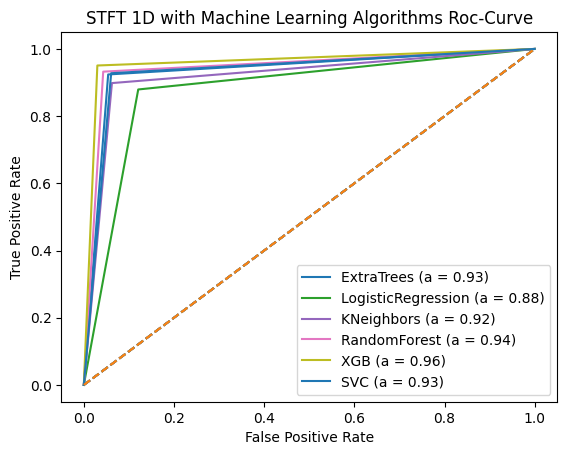

In [20]:
Accuracy_set, models = evaluate_classifiers(classifiers)

In [21]:
Accuracy_set.sort_values(by='Accuracy(Test)').style.background_gradient(cmap= plt.cm.Blues)

,Model,Accuracy(Train),Accuracy(Test),F1(Train),F1(Test),Precision(Train),Precision(Test),Recall(Train),Recall(Test),Log_loss(Train),Log_loss(Test),Train_Time(s),Confusion_Matrix(Test),Optimal_Params
1,LogisticRegression,0.908214,0.879333,0.908214,0.879333,0.908214,0.879333,0.908214,0.879333,0.237489,0.337955,254.461613,[[2638 362] [ 362 2638]],"{'solver': 'liblinear', 'penalty': 'l2', 'C': 1}"
2,KNeighborsClassifier,1.000000,0.918000,1.000000,0.918000,1.000000,0.918000,1.000000,0.918000,0.000000,0.364166,1440.114848,[[2813 187] [ 305 2695]],"{'weights': 'distance', 'n_neighbors': 6, 'metric': 'euclidean', 'algorithm': 'ball_tree'}"
5,SVC,0.999857,0.933500,0.999857,0.933500,0.999857,0.933500,0.999857,0.933500,0.660055,0.668730,11904.541218,[[2818 182] [ 217 2783]],"{'C': 1.9919553742964715, 'gamma': 0.051922896891217, 'kernel': 'poly'}"
0,ExtraTreesClassifier,0.975571,0.935000,0.975571,0.935000,0.975571,0.935000,0.975571,0.935000,0.198893,0.256075,1286.513890,[[2838 162] [ 228 2772]],"{'n_estimators': 100, 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_features': 350}"
3,RandomForestClassifier,1.000000,0.944667,1.000000,0.944667,1.000000,0.944667,1.000000,0.944667,0.057226,0.227556,3815.718546,[[2871 129] [ 203 2797]],"{'n_estimators': 1000, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 18, 'max_depth': None, 'criterion': 'log_loss', 'bootstrap': False}"
4,XGBClassifier,1.000000,0.960333,1.000000,0.960333,1.000000,0.960333,1.000000,0.960333,0.016372,0.103164,622.263393,[[2910 90] [ 148 2852]],"{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 1.0}"


In [26]:
for index in range(len(models)):
    print("Model name: ", Accuracy_set["Model"][index])
    print("Accuracy in Test: ", (Accuracy_set['Accuracy(Test)'][index])*100, "%\nOptimal_Params: ", Accuracy_set["Optimal_Params"][index])

Model name:  ExtraTreesClassifier
Accuracy in Test:  93.5 %
Optimal_Params:  {'n_estimators': 100, 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_features': 350}
Model name:  LogisticRegression
Accuracy in Test:  87.93333333333334 %
Optimal_Params:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Model name:  KNeighborsClassifier
Accuracy in Test:  91.8 %
Optimal_Params:  {'weights': 'distance', 'n_neighbors': 6, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Model name:  RandomForestClassifier
Accuracy in Test:  94.46666666666667 %
Optimal_Params:  {'n_estimators': 1000, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 18, 'max_depth': None, 'criterion': 'log_loss', 'bootstrap': False}
Model name:  XGBClassifier
Accuracy in Test:  96.03333333333333 %
Optimal_Params:  {'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 1.0}
Model name:  SVC
Accuracy in Test:  93.35 %
Optimal_Params:  {'C': 1.9919553742964715, 'gamma': 0.0

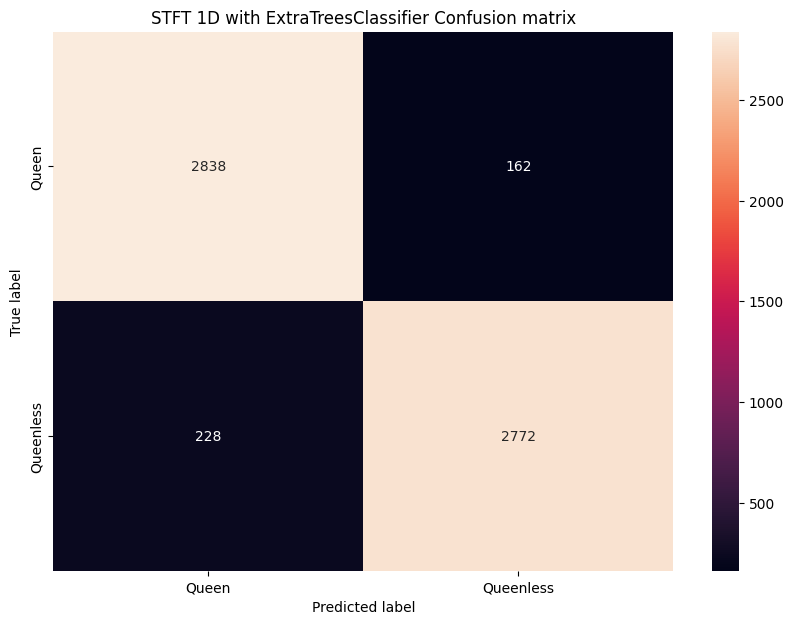

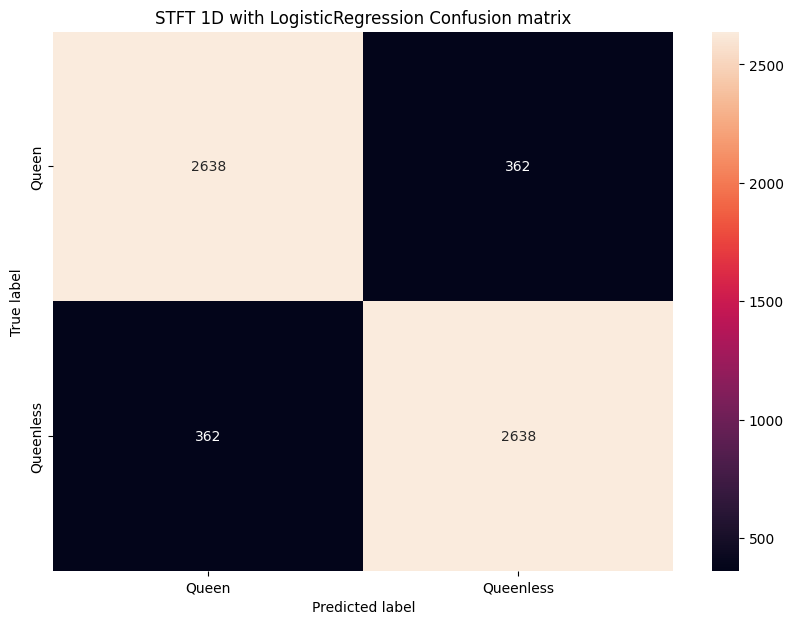

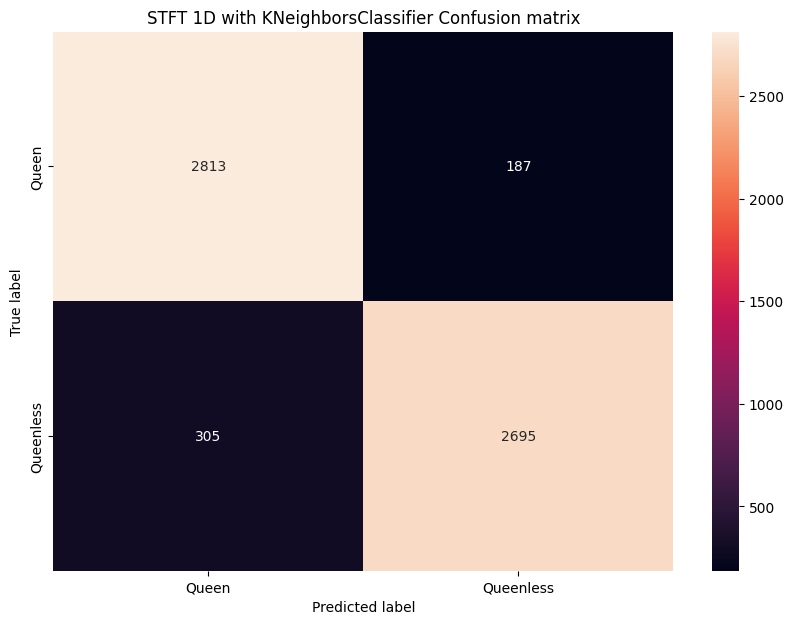

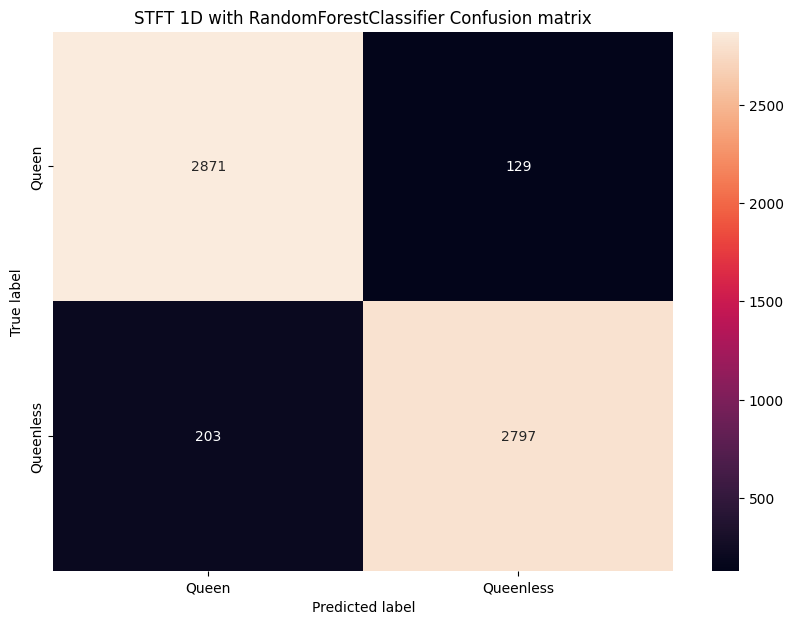

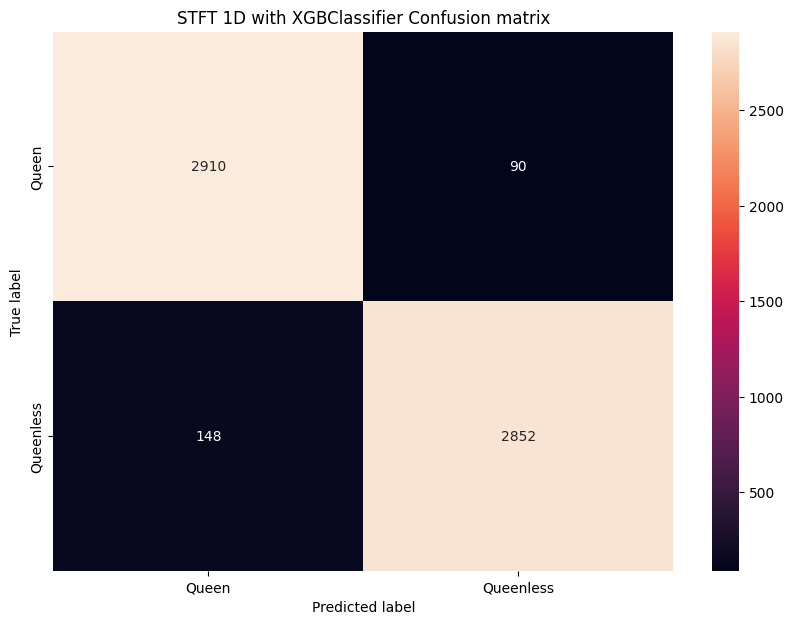

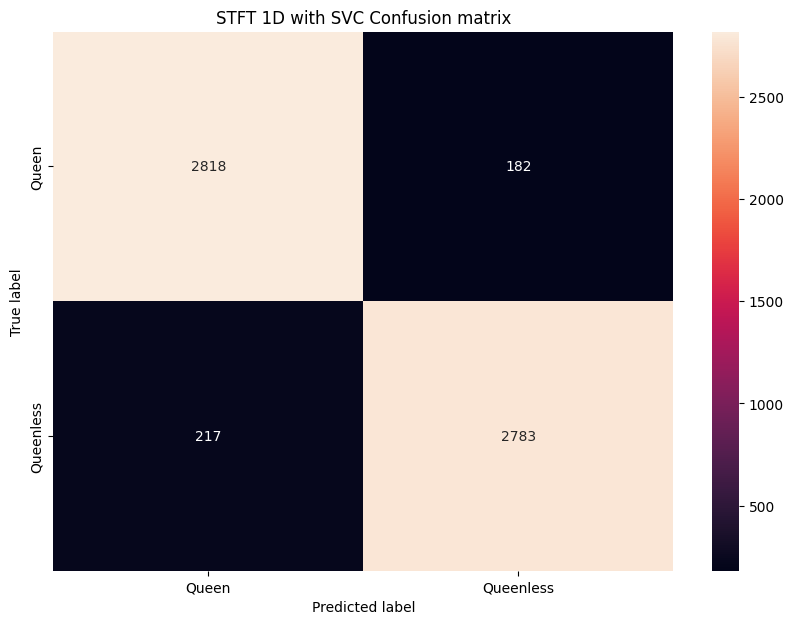

In [23]:
for index in range(len(Accuracy_set['Accuracy(Test)'])):
    plot_confusion_matrix(Accuracy_set['Confusion_Matrix(Test)'][index], "STFT 1D with {} Confusion matrix".format(Accuracy_set['Model'][index]))
    

In [27]:
# os.chdir(os.path.join(os.getcwd(), 'model'))
import pickle
for index in range(len(models)):
    model_name = models[index][0]
    model = models[index][-1]
    pickle.dump(model, open(model_name + "_STFT_RandomSearchCV_Sequential_ML.pkl", 'wb'))